In [2]:
import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

In [3]:
train = pd.read_csv('/kaggle/input/kvasirinstrument/kvasir-instrument/train.txt')

<Figure size 432x288 with 0 Axes>

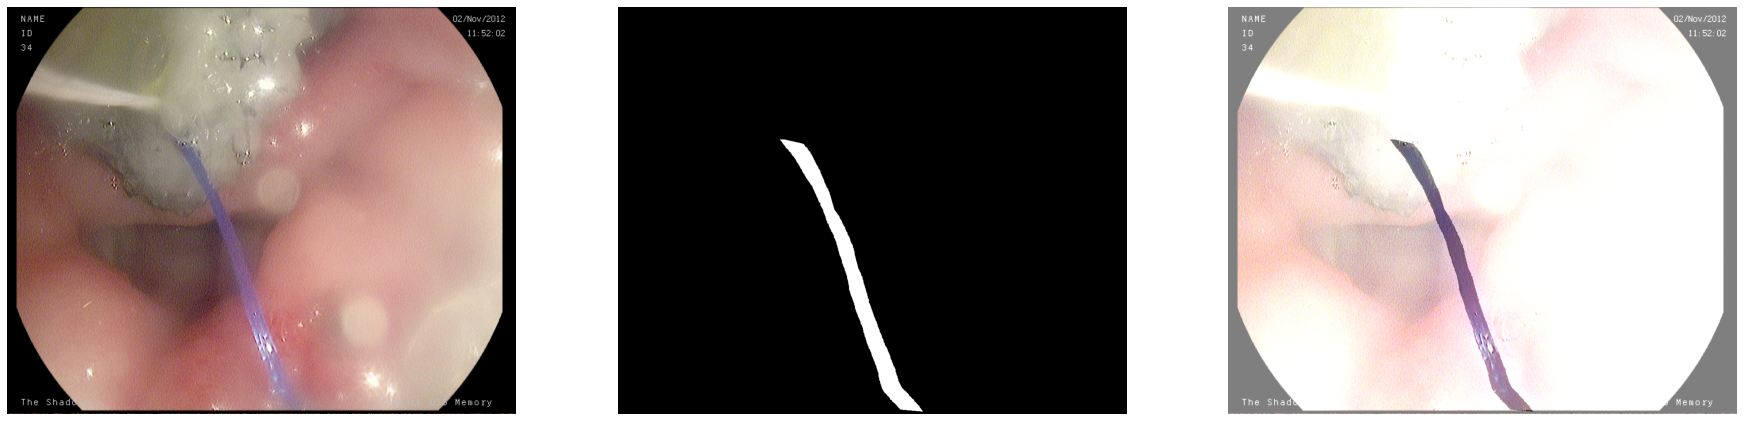

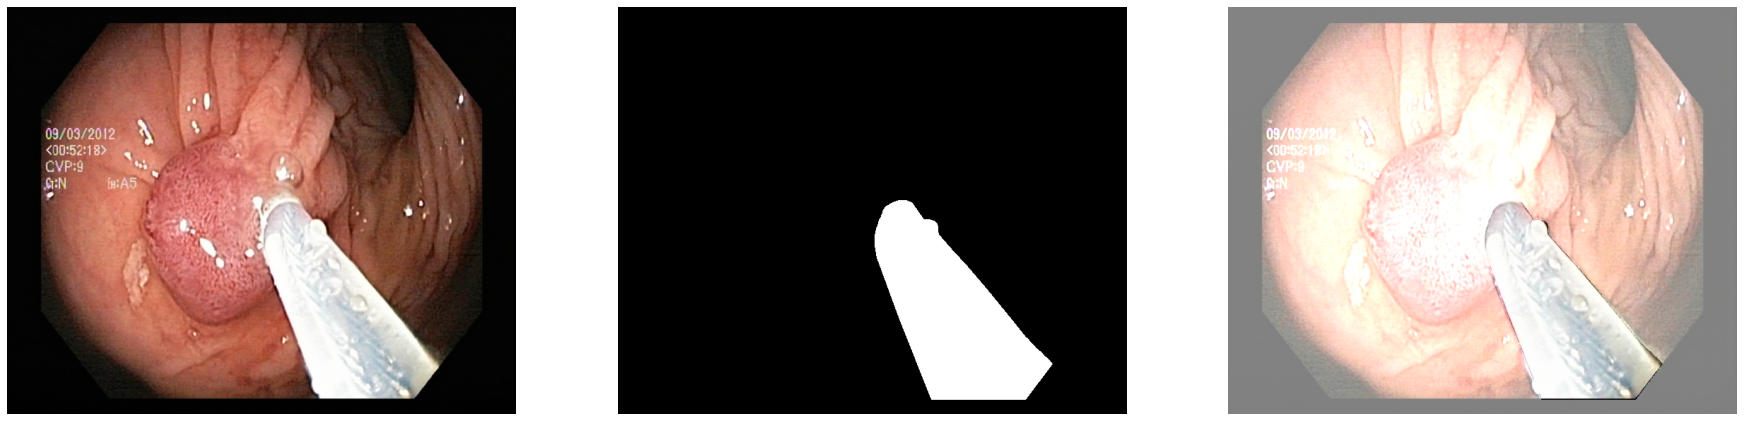

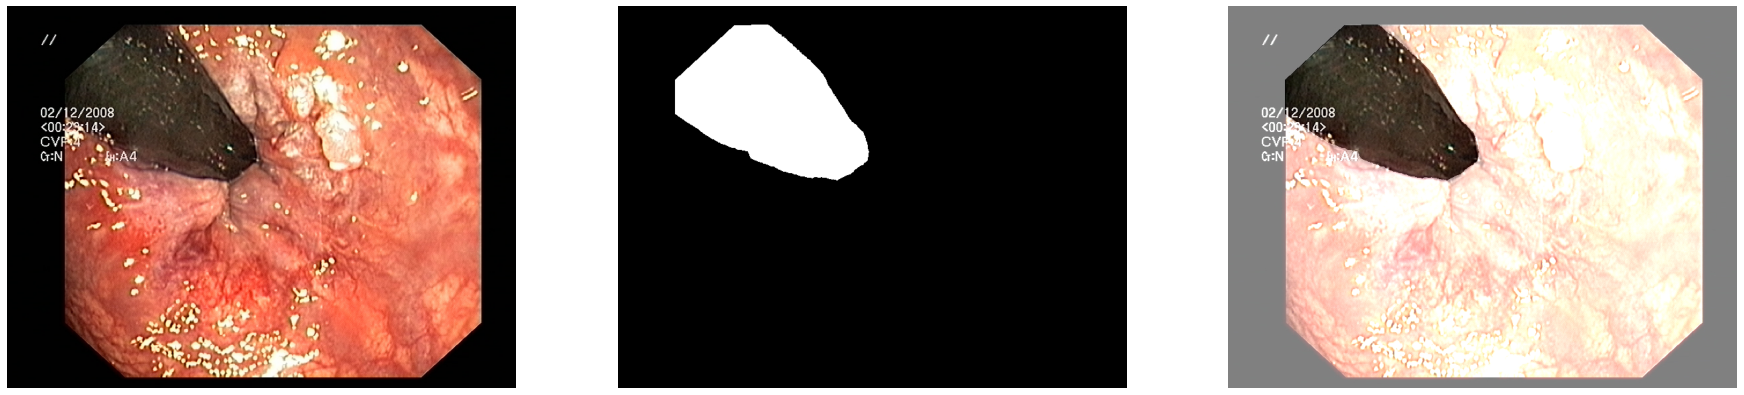

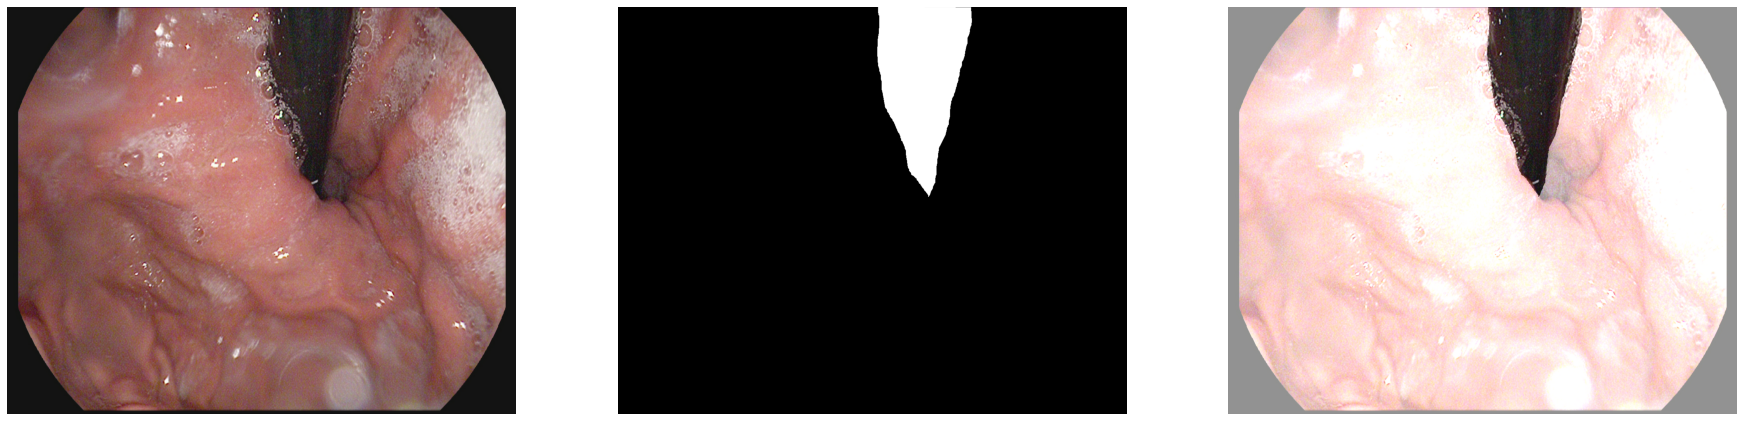

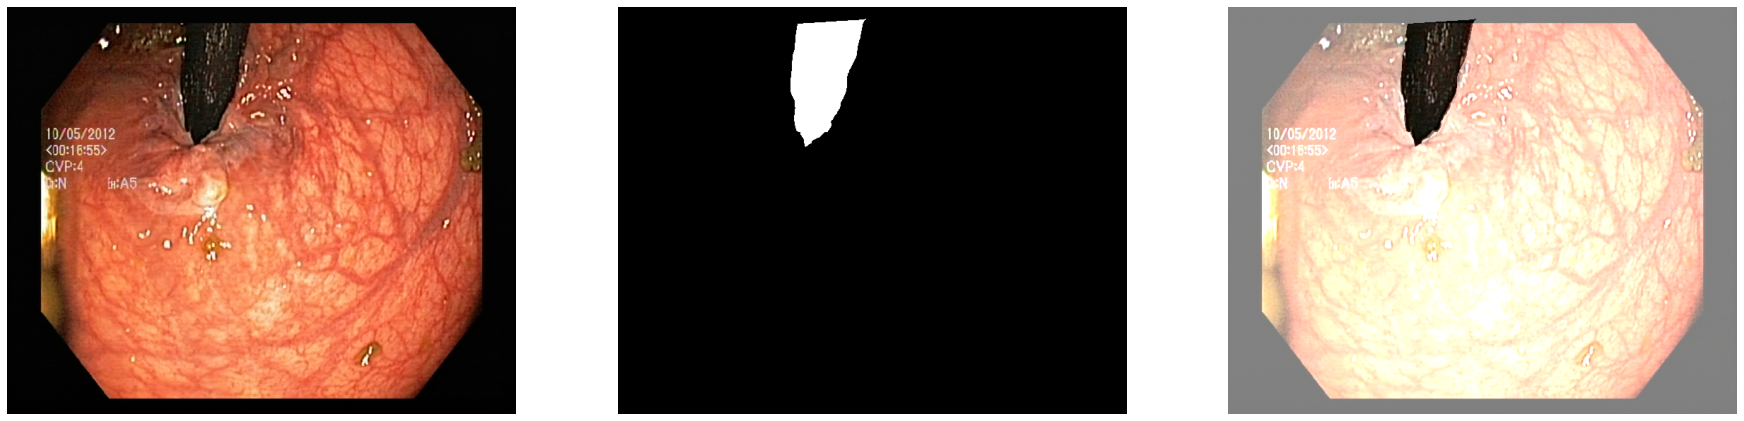

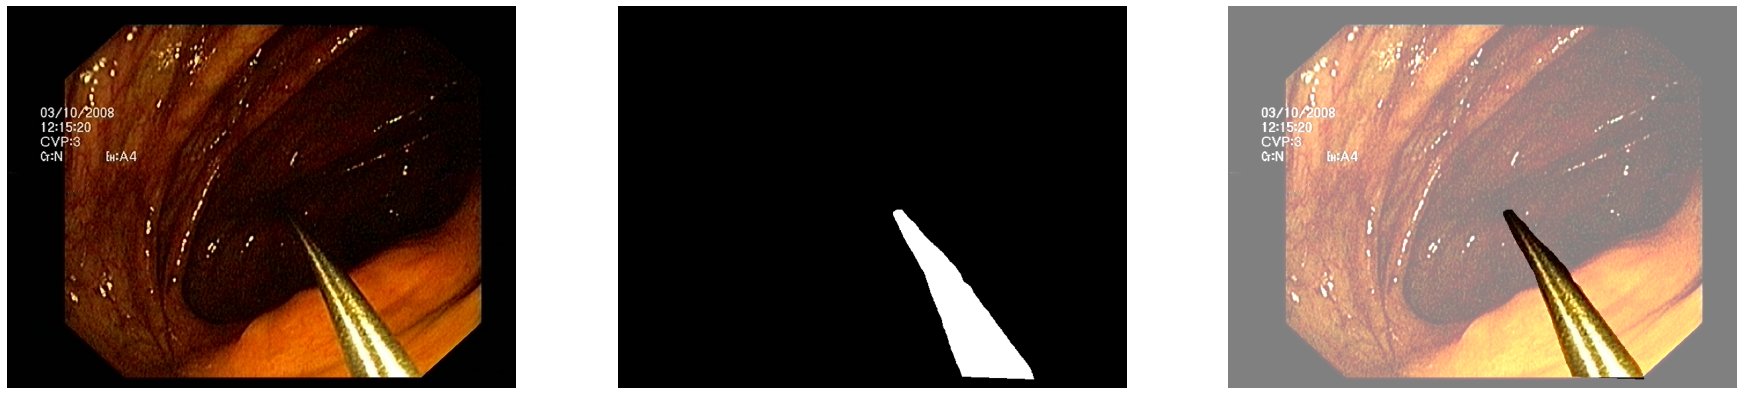

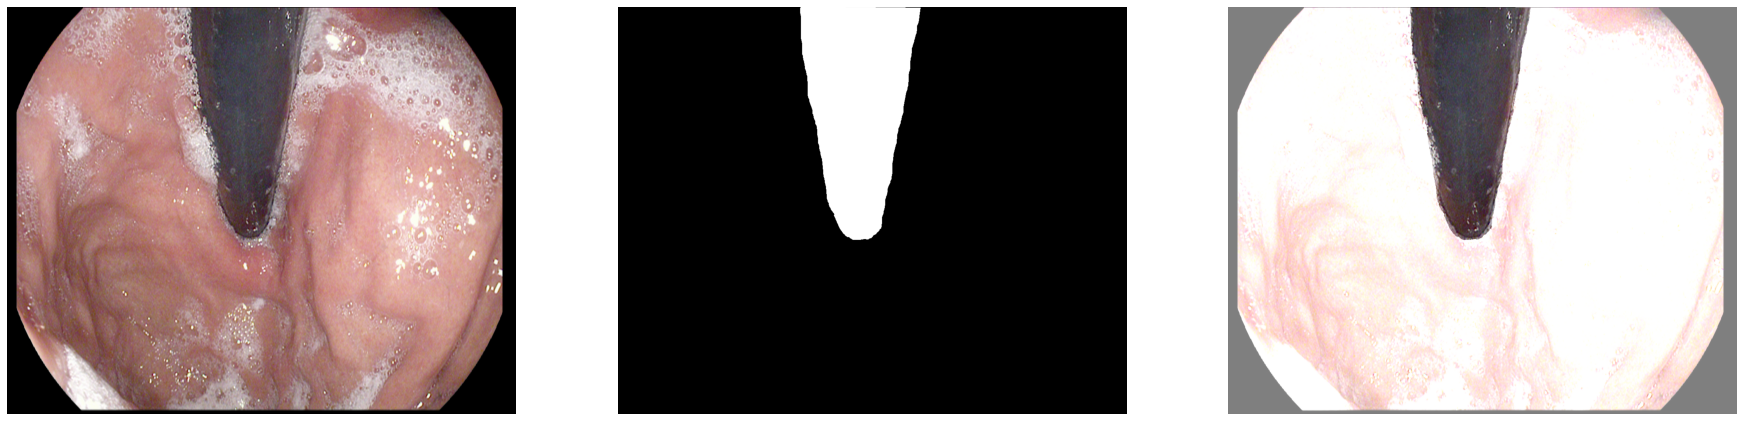

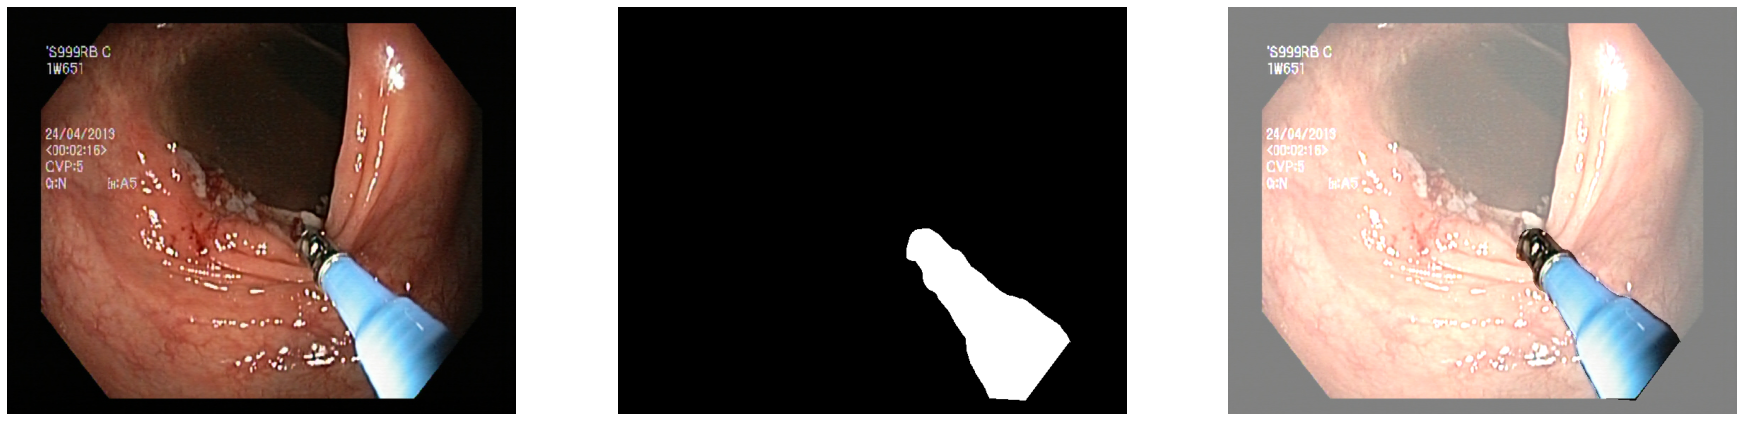

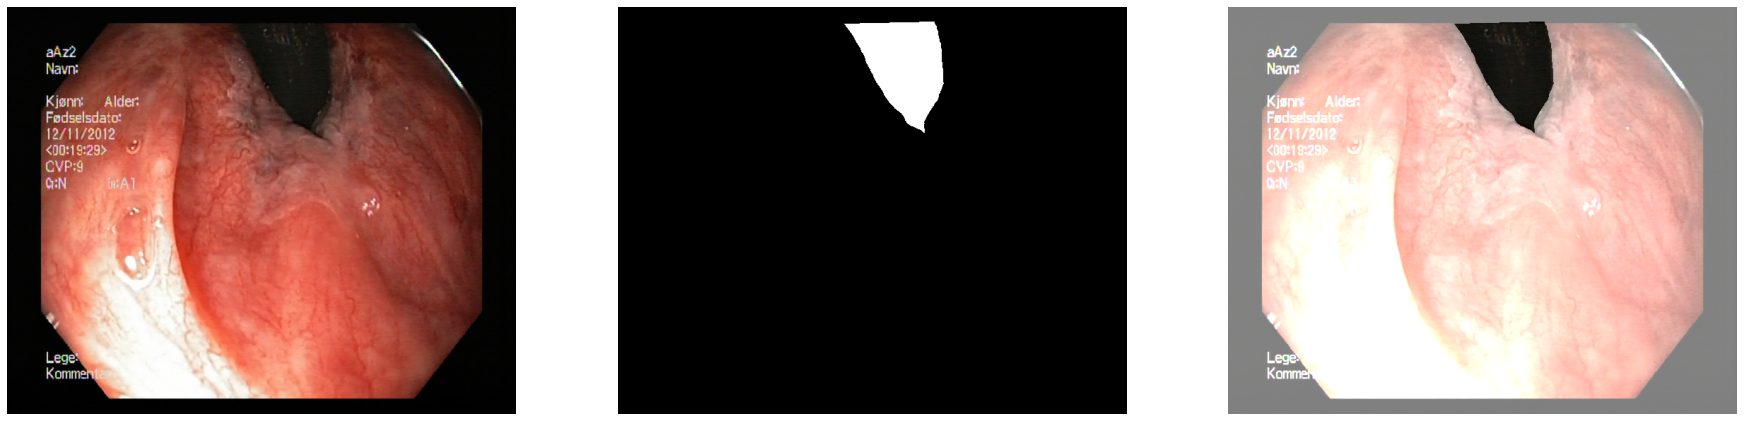

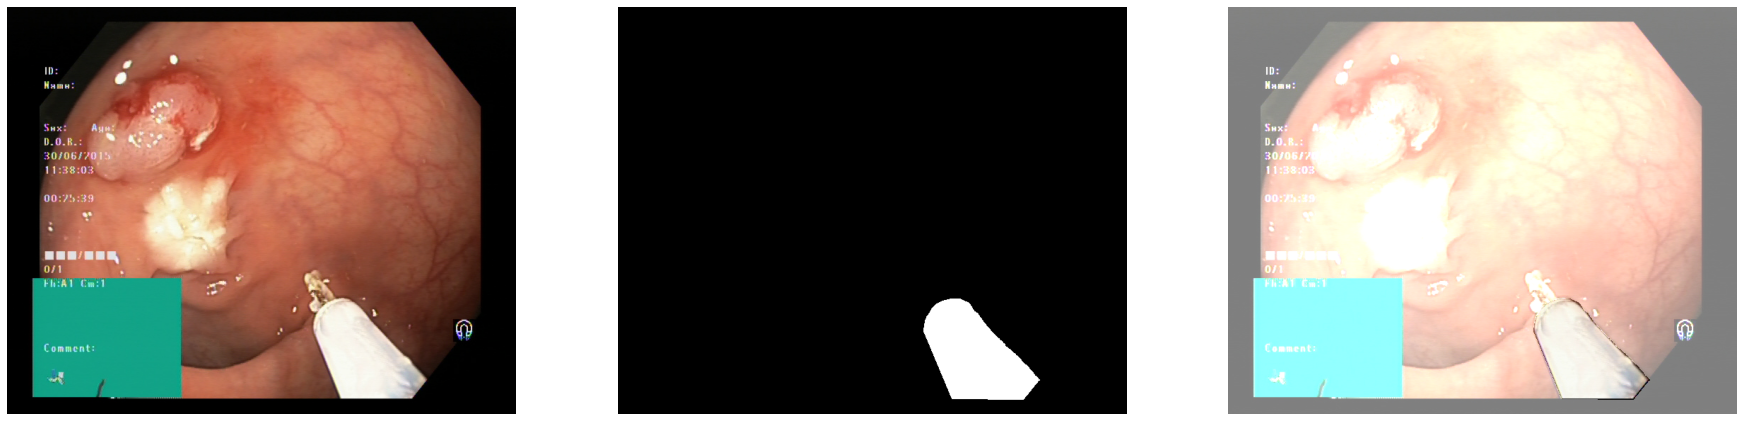

In [4]:
for i in range(10):
    
    name = train.values[i][0]
    name

    img_name = '/kaggle/input/kvasirinstrument/kvasir-instrument/images/images/'+ name + '.jpg'
    img_mask = '/kaggle/input/kvasirinstrument/kvasir-instrument/masks/masks/' + name + '.png'
    
    
    plt.figure(i)
    plt.figure(figsize = (31, 10))
    plt.subplot(131)
    img = plt.imread(img_name)
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(132)
    mask = plt.imread(img_mask)
    plt.imshow(mask)
    plt.axis('off')

    plt.subplot(133)
    ma = mask.astype('uint8')*255
    plt.imshow(img.astype('uint8')/255+(1-mask)*0.5)
    plt.axis('off')

In [5]:
len(train)

471

In [6]:
from numpy import savez_compressed

In [7]:
images_ = []
masks_ =  []
size=(256,256)
for i in range(len(train)):
    name = train.values[i][0]
    

    img_name = '/kaggle/input/kvasirinstrument/kvasir-instrument/images/images/'+ name + '.jpg'
    img_mask = '/kaggle/input/kvasirinstrument/kvasir-instrument/masks/masks/' + name + '.png'
    
    
    
    img = load_img(img_name, target_size=size)
    img = img_to_array(img)
    
    mask = load_img(img_mask, target_size=size)
    mask = img_to_array(mask)
    images_.append(img)
    masks_.append(mask)
    
images_ =  np.array(images_)
masks_ = np.array(masks_)
print(images_.shape, masks_.shape)
filename = 'maps_256.npz'
savez_compressed(filename, images_, masks_)

(471, 256, 256, 3) (471, 256, 256, 3)


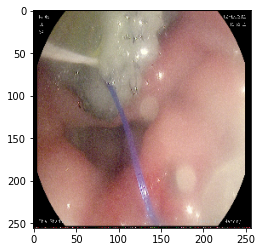

In [8]:
plt.imshow(images_[0]/255)

In [9]:
test = pd.read_csv('/kaggle/input/kvasirinstrument/kvasir-instrument/test.txt')
images_ = []
masks_ =  []
size=(256,256)
for i in range(len(test)):
    name = test.values[i][0]
    

    img_name = '/kaggle/input/kvasirinstrument/kvasir-instrument/images/images/'+ name + '.jpg'
    img_mask = '/kaggle/input/kvasirinstrument/kvasir-instrument/masks/masks/' + name + '.png'
    
    
    
    img = load_img(img_name, target_size=size)
    img = img_to_array(img)
    
    mask = load_img(img_mask, target_size=size)
    mask = img_to_array(mask)
    images_.append(img)
    masks_.append(mask)
    
images_ =  np.array(images_)
masks_ = np.array(masks_)
print(images_.shape, masks_.shape)
filename1 = 'testmaps_256.npz'
savez_compressed(filename1, images_, masks_)

(117, 256, 256, 3) (117, 256, 256, 3)


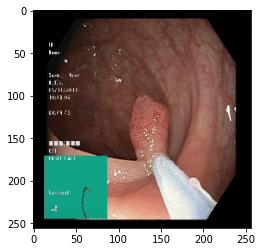

In [10]:
plt.imshow(images_[0]/255)

In [11]:
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import savez_compressed
import matplotlib.pyplot as plt 
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import listdir
from numpy import asarray

from pydicom import dcmread

import glob 
from os import listdir
from numpy import asarray
from numpy import vstack

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from numpy import savez_compressed
import numpy as np 
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from matplotlib import pyplot

In [12]:
def plotMask(X,y):
    sample = []
    
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i].astype('uint8'))
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1].astype('uint8'))
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2].astype('uint8'))
        
        plt.show()

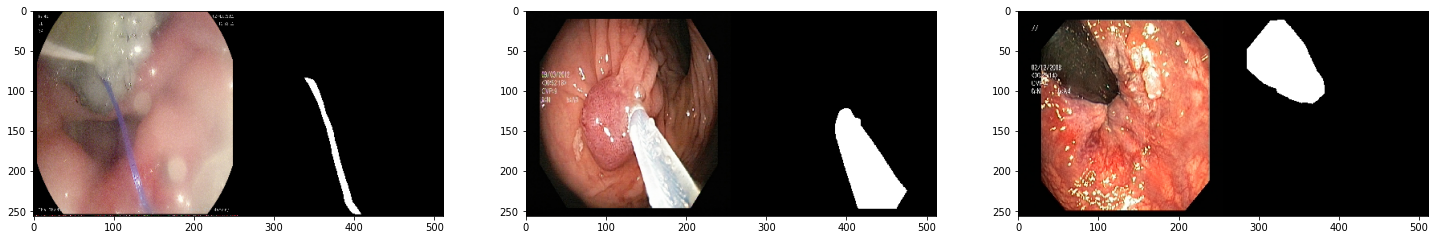

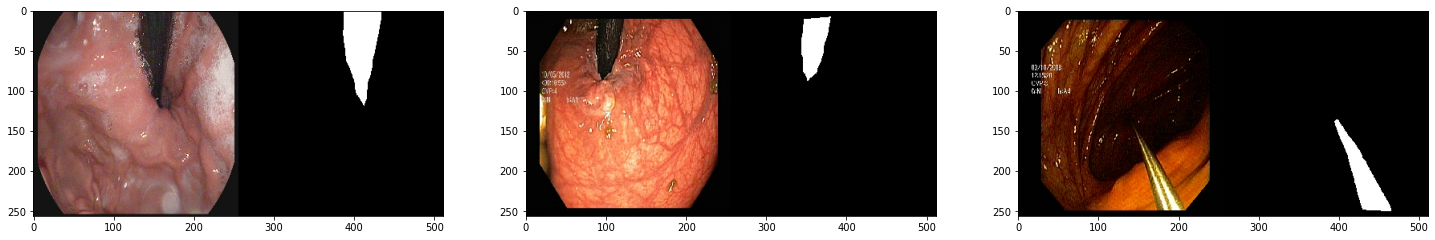

In [13]:
# Load training and testing data
datatrain = load(filename)
X_train, y_train = datatrain['arr_0'], datatrain['arr_1']
plotMask(X_train, y_train)

In [14]:
assert X_train.shape == y_train.shape

In [15]:
images = X_train
mask  = y_train

# model

In [16]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', dtype='float32')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(3, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [17]:
model = unet(input_size=(256,256,3))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3,
                                   verbose=1, mode='min', epsilon=0.0002, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [19]:
from IPython.display import clear_output
from tensorflow.keras.optimizers import Adam 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
model.compile(optimizer=Adam(lr=0.00001), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy', 'AUC'])

train_vol, validation_vol, train_seg, validation_seg = train_test_split((images)/255, 
                                                            (mask>127).astype(np.float32), 
                                                            test_size = 0.1,random_state = 2018)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
                                                            test_size = 0.1, 
                                                            random_state = 2018)

In [20]:
len(train_vol)

380

In [21]:
len(test_vol)

43

In [22]:
len(validation_vol)

48

Text(0.5, 1.0, 'validation')

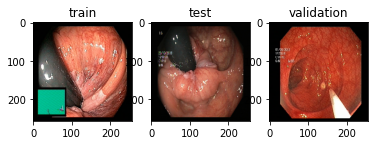

In [23]:

plt.subplot(131)
plt.imshow(train_vol[0])
plt.title('train')

plt.subplot(132)
plt.imshow(test_vol[0])
plt.title('test')

plt.subplot(133)
plt.imshow(validation_vol[0])
plt.title('validation')

In [24]:
loss_history = model.fit(x = train_vol,y = train_seg,batch_size = 8,epochs = 1000,validation_data =(test_vol,test_seg) , callbacks=callbacks_list)

model.save('model.h5')

Epoch 1/1000
48/48 [==============================] - 19s 216ms/step - loss: -0.1644 - dice_coef: 0.1644 - binary_accuracy: 0.3381 - auc: 0.5148 - val_loss: -0.1767 - val_dice_coef: 0.1817 - val_binary_accuracy: 0.3047 - val_auc: 0.5339

Epoch 00001: val_loss improved from inf to -0.17668, saving model to cxr_reg_weights.best.hdf5
Epoch 2/1000
48/48 [==============================] - 8s 165ms/step - loss: -0.1638 - dice_coef: 0.1638 - binary_accuracy: 0.3039 - auc: 0.5373 - val_loss: -0.1775 - val_dice_coef: 0.1827 - val_binary_accuracy: 0.2985 - val_auc: 0.5627

Epoch 00002: val_loss improved from -0.17668 to -0.17754, saving model to cxr_reg_weights.best.hdf5
Epoch 3/1000
48/48 [==============================] - 8s 165ms/step - loss: -0.1699 - dice_coef: 0.1699 - binary_accuracy: 0.2977 - auc: 0.5637 - val_loss: -0.1792 - val_dice_coef: 0.1845 - val_binary_accuracy: 0.2896 - val_auc: 0.6147

Epoch 00003: val_loss improved from -0.17754 to -0.17917, saving model to cxr_reg_weights.bes

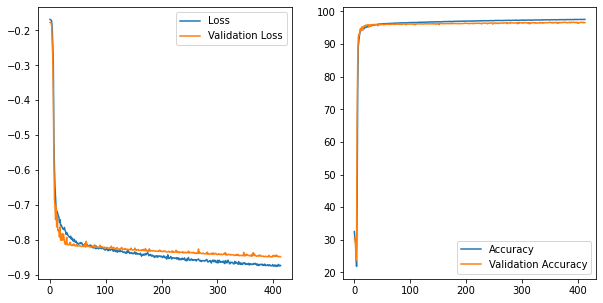

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',label = 'Validation Accuracy')
ax2.legend()